In [27]:
import psycopg2

import numpy as np
import pandas as pd
pd.options.display.max_colwidth = 200
import polars as pl

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]

from pprint import pprint
from collections import OrderedDict

from clickhouse_driver import Client

client = Client('localhost', database="thesisproxyoccupancytimeoutdb")

In [28]:
%%time 

exp_data_sql = """
SELECT
	ex.*
FROM
	experiment ex
"""
exp_df = client.query_dataframe(exp_data_sql)

exp_df = exp_df.astype({
	"request_timeout": "int32"
})

print(len(exp_df.exp_id.unique().tolist()))
print("\n".join(exp_df.exp_id.unique().tolist()))
print()
exp_df

10
thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client
thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client
thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_30sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client
thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_30sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client
thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_45sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client
thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_45sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client
thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_coap_https__140sec_proxy__30sec_attacke

,exp_id,attacker_rate,server_connections,max_keep_alive_requests,num_clients,num_trials,origin_server_duration,attacker_duration,receiver_duration,proxy_duration,...,topology_name,num_proxy_connections,request_timeout,max_retries,keep_alive_duration,request_retry_interval,reuse_connections,run_proxy_with_dtls,run_proxy_with_https,run_attacker
0,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client,100mbps,256,0,8,5,140,30,140,140,...,thesis_cloud_proxy_and_internet_attacker,50,15,2,5,1,True,False,True,True
1,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client,100mbps,256,0,8,5,140,30,140,140,...,thesis_cloud_proxy_and_internet_attacker,50,15,2,5,1,True,True,True,True
2,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_30sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client,100mbps,256,0,8,5,140,30,140,140,...,thesis_cloud_proxy_and_internet_attacker,50,30,2,5,1,True,False,True,True
3,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_30sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client,100mbps,256,0,8,5,140,30,140,140,...,thesis_cloud_proxy_and_internet_attacker,50,30,2,5,1,True,True,True,True
4,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_45sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client,100mbps,256,0,8,5,140,30,140,140,...,thesis_cloud_proxy_and_internet_attacker,50,45,2,5,1,True,False,True,True
5,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_45sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client,100mbps,256,0,8,5,140,30,140,140,...,thesis_cloud_proxy_and_internet_attacker,50,45,2,5,1,True,True,True,True
6,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client,100mbps,256,0,8,5,140,30,140,140,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,True,False,True,True
7,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client,100mbps,256,0,8,5,140,30,140,140,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,True,True,True,True
8,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client,100mbps,256,0,8,5,140,30,140,140,...,thesis_cloud_proxy_and_internet_attacker,50,60,2,5,1,True,False,True,True
9,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client,100mbps,256,0,8,5,140,30,140,140,...,thesis_cloud_proxy_and_internet_attacker,50,60,2,5,1,True,True,True,True


In [30]:
%%time 

fetch_metadata_sql = """
SELECT
	n.node_name,
	dn.dnid,
	dn.node_id,
  dn.exp_id
FROM 
	deployed_node dn
	JOIN node n ON n.node_id = dn.node_id
"""

metadata_df = client.query_dataframe(fetch_metadata_sql)

dnid_map_node_name = dict()
dnid_map_exp_id = dict()
node_id_map_node_name = dict()

for record in metadata_df.to_dict(orient="records"):
  dnid = record["dnid"]
  node_id = record["node_id"]
  node_name = record["node_name"]
  exp_id = record["exp_id"]
  
  assert dnid not in dnid_map_node_name
  dnid_map_node_name[dnid] = node_name
  dnid_map_exp_id[dnid] = exp_id
  
  if node_id in node_id_map_node_name:
    assert node_id_map_node_name[node_id] == node_name
  else:
    node_id_map_node_name[node_id] = node_name
  
client_dnids = set(dnid for dnid, node_name in dnid_map_node_name.items() if node_name.startswith("client"))
attacker_dnids = set(dnid for dnid, node_name in dnid_map_node_name.items() if node_name.startswith("attacker"))

client_node_ids = set(node_id for node_id, node_name in node_id_map_node_name.items() if node_name.startswith("client"))

print(f"{client_dnids=}")
print(f"{attacker_dnids=}")
print(f"{client_node_ids=}")

client_dnids={2, 3, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 18, 19, 20, 21, 26, 27, 28, 29, 30, 31, 32, 33, 38, 39, 40, 41, 42, 43, 44, 45, 50, 51, 52, 53, 54, 55, 56, 57, 62, 63, 64, 65, 66, 67, 68, 69, 74, 75, 76, 77, 78, 79, 80, 81, 86, 87, 88, 89, 90, 91, 92, 93, 98, 99, 100, 101, 102, 103, 104, 105, 110, 111, 112, 113, 114, 115, 116, 117}
attacker_dnids={1, 97, 37, 73, 13, 109, 49, 85, 25, 61}
client_node_ids={2, 3, 4, 5, 6, 7, 8, 9}
CPU times: user 8.43 ms, sys: 245 µs, total: 8.68 ms
Wall time: 14.5 ms


In [31]:
%%time

client_messages_sql = f"""
WITH client_sends AS (
  SELECT
    dn.exp_id AS exp_id,
    e.observe_timestamp AS observe_timestamp,
    e.trial AS trial,
    e.observer_id AS observer_id,
    e.message_marker AS message_marker,
    cm.coap_retransmitted AS coap_retransmitted
  FROM
    event e
    JOIN message m ON m.message_id = e.message_id
    JOIN coap_message cm ON cm.cmci = m.coap_message
    JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE
    e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
    AND m.src_id IN ({','.join(map(str, client_node_ids))}) -- clients are senders (node ID)
), 

client_recvs AS (
  SELECT
    e.observe_timestamp AS observe_timestamp,
    e.trial AS trial,
    e.observer_id AS observer_id,
    e.message_marker AS message_marker,
    cm.coap_code AS response_code
  FROM
    event e
    JOIN message m ON m.message_id = e.message_id
    JOIN coap_message cm ON cm.cmci = m.coap_message
  WHERE
    e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
    AND m.dst_id IN ({','.join(map(str, client_node_ids))}) -- clients are receivers (node ID)
)

SELECT
  client_sends.exp_id AS exp_id,
  client_sends.trial AS trial,
  client_sends.observer_id AS observer_id,
  client_sends.message_marker AS message_marker,
  groupArray(client_recvs.response_code)[1] AS response_code,
  MIN(client_sends.observe_timestamp) AS send_time_sec,
  MIN(client_recvs.observe_timestamp) AS recv_time_sec,
  MIN(client_sends.observe_timestamp) AS first_send_time_sec,
  MAX(client_sends.observe_timestamp) AS last_send_time_sec,
  MIN(client_recvs.observe_timestamp) AS first_recv_time_sec,
  MAX(client_recvs.observe_timestamp) AS last_recv_time_sec,
  1e3 * (MIN(client_recvs.observe_timestamp) - MIN(client_sends.observe_timestamp)) AS rtt_ms_first_transmission,
  1e3 * (MIN(client_recvs.observe_timestamp) - MAX(client_sends.observe_timestamp)) AS rtt_ms_last_transmission,
  COUNT(client_sends.observe_timestamp) AS num_send_observations,
  COUNT(client_recvs.observe_timestamp) AS num_recv_observations,
  SUM(CASE WHEN client_sends.coap_retransmitted = true THEN 1 ELSE 0 END) AS num_retransmissions
FROM client_sends
  LEFT JOIN client_recvs USING (trial, observer_id, message_marker)
GROUP BY 
  exp_id, trial, observer_id, message_marker
ORDER BY
  exp_id, trial, observer_id, message_marker
"""

message_rtt_df = client.query_dataframe(client_messages_sql)
message_rtt_df.observer_id.replace(dnid_map_node_name, inplace=True)

message_rtt_df["successful_message"] = False
message_rtt_df.loc[(message_rtt_df["response_code"] == "content"), "successful_message"] = True

print(message_rtt_df["response_code"].unique())

message_rtt_df = message_rtt_df.merge(exp_df, on="exp_id", how="left")

# Due to left join, we need to eliminate lines that
# have negative RTT, so we NaN them.
message_rtt_df.loc[
  (message_rtt_df["rtt_ms_first_transmission"] < 0)
  | (message_rtt_df["rtt_ms_last_transmission"] < 0)
  ,
  ["rtt_ms_first_transmission", "rtt_ms_last_transmission"]
] = np.nan

message_rtt_df

['content' 'bad_gateway' '']
CPU times: user 2.19 s, sys: 715 ms, total: 2.9 s
Wall time: 4.92 s


,exp_id,trial,observer_id,message_marker,response_code,send_time_sec,recv_time_sec,first_send_time_sec,last_send_time_sec,first_recv_time_sec,...,topology_name,num_proxy_connections,request_timeout,max_retries,keep_alive_duration,request_retry_interval,reuse_connections,run_proxy_with_dtls,run_proxy_with_https,run_attacker
0,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,client1,1,content,0.000000,0.351116,0.000000,0.000000,0.351116,...,thesis_cloud_proxy_and_internet_attacker,50,15,2,5,1,True,False,True,True
1,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,client1,2,content,0.368913,0.428905,0.368913,0.368913,0.428905,...,thesis_cloud_proxy_and_internet_attacker,50,15,2,5,1,True,False,True,True
2,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,client1,3,content,0.431380,0.489696,0.431380,0.431380,0.489696,...,thesis_cloud_proxy_and_internet_attacker,50,15,2,5,1,True,False,True,True
3,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,client1,4,content,0.492094,0.549362,0.492094,0.492094,0.549362,...,thesis_cloud_proxy_and_internet_attacker,50,15,2,5,1,True,False,True,True
4,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,client1,5,content,0.551819,0.608503,0.551819,0.551819,0.608503,...,thesis_cloud_proxy_and_internet_attacker,50,15,2,5,1,True,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440827,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client,5,client8,4954,content,37.290514,37.490319,37.290514,37.290514,37.490319,...,thesis_cloud_proxy_and_internet_attacker,50,60,2,5,1,True,True,True,True
440828,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client,5,client8,9438,content,37.491369,38.312782,37.491369,37.491369,38.312782,...,thesis_cloud_proxy_and_internet_attacker,50,60,2,5,1,True,True,True,True
440829,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client,5,client8,29145,content,38.313905,41.091341,38.313905,40.531516,41.091341,...,thesis_cloud_proxy_and_internet_attacker,50,60,2,5,1,True,True,True,True
440830,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client,5,client8,95827,content,41.092547,83.919629,41.092547,76.149647,83.919629,...,thesis_cloud_proxy_and_internet_attacker,50,60,2,5,1,True,True,True,True


In [32]:
%%time

(
  message_rtt_df.groupby(by=["exp_id", "trial", "observer_id"])
  .agg(
    avg_rtt_ms_first_transmission=("rtt_ms_first_transmission", "mean"),
    avg_rtt_ms_last_transmission=("rtt_ms_last_transmission", "mean"),
    num_unique_messages=("message_marker", "nunique"),
    num_messages=("message_marker", "count"),
    num_successful_messages=("successful_message", "sum"),
    num_send_messages=("num_send_observations", "sum"),
    num_recv_messages=("num_recv_observations", "sum"),
    max_num_retransmissions=("num_retransmissions", "max"),
    total_num_retransmissions=("num_retransmissions", "sum"),
  )
)

CPU times: user 328 ms, sys: 7.65 ms, total: 336 ms
Wall time: 333 ms


avg_rtt_ms_first_transmission  \
exp_id                                                                                                                                           trial observer_id                                  
thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client 1     client1                          85.234520   
                                                                                                                                                       client2                          84.717530   
                                                                                                                                                       client3                          84.862993   
                                                                                                                                                       client4                          84.669244   
                                                                                                                                                       client5                          84.571816   
...                                                                                                                                                                                           ...   
thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client 5     client4                          93.470190   
                                                                                                                                                       client5                         102.605018   
                                                                                                                                                       client6                         133.752764   
                                                                                                                                                       client7                         119.351079   
                                                                                                                                                       client8                         135.998669   

                                                                                                                                                                    avg_rtt_ms_last_transmission  \
exp_id                                                                                                                                           trial observer_id                                 
thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client 1     client1                         67.274062   
                                                                                                                                                       client2                         65.723495   
                                                                                                                                                       client3                         66.200171   
                                                                                                                                                       client4                         66.560658   
                                                                                                                                                       client5                         66.563602   
...                                                                                                                                                                                          ...   
thesis_group_proxy_occ_timeout_8cl

In [33]:
%%time

metric_usage_sql = f"""
SELECT
	dn.exp_id,
	nm.trial,
	nm.observer_id,
	nm.metric_type,
	AVG(nm.metric_value) AS avg_value,
	MIN(nm.metric_value) AS min_value,
	MAX(nm.metric_value) AS max_value
FROM
	node_metric nm
	JOIN deployed_node dn ON dn.dnid = nm.observer_id
GROUP BY
	dn.exp_id, nm.trial, nm.observer_id, nm.metric_type
ORDER BY
	dn.exp_id, nm.trial, nm.metric_type, nm.observer_id
"""

metric_df = client.query_dataframe(metric_usage_sql)

metric_df.observer_id.replace(dnid_map_node_name, inplace=True)

metric_df = metric_df.merge(exp_df, on="exp_id", how="left")

metric_df

CPU times: user 28 ms, sys: 368 µs, total: 28.4 ms
Wall time: 95.8 ms


,exp_id,trial,observer_id,metric_type,avg_value,min_value,max_value,attacker_rate,server_connections,max_keep_alive_requests,...,topology_name,num_proxy_connections,request_timeout,max_retries,keep_alive_duration,request_retry_interval,reuse_connections,run_proxy_with_dtls,run_proxy_with_https,run_attacker
0,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,originserver,cpu_utilization,6.491429,0.4,23.7,100mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,15,2,5,1,True,False,True,True
1,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,proxy,cpu_utilization,17.980714,0.5,84.2,100mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,15,2,5,1,True,False,True,True
2,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,originserver,memory_utilization,267.271523,242.0,298.0,100mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,15,2,5,1,True,False,True,True
3,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,proxy,memory_utilization,3619.836394,248.0,6077.0,100mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,15,2,5,1,True,False,True,True
4,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client,2,originserver,cpu_utilization,6.098571,0.5,22.1,100mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,15,2,5,1,True,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client,4,proxy,memory_utilization,3628.232441,252.0,6385.0,100mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,60,2,5,1,True,True,True,True
196,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client,5,originserver,cpu_utilization,13.940714,0.4,26.7,100mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,60,2,5,1,True,True,True,True
197,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client,5,proxy,cpu_utilization,24.487857,0.4,85.7,100mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,60,2,5,1,True,True,True,True
198,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client,5,originserver,memory_utilization,285.458472,256.0,335.0,100mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,60,2,5,1,True,True,True,True


In [34]:
%%time

client_rps_df = (
  message_rtt_df
  .groupby(by=["exp_id", "trial", "observer_id"])
  .aggregate(
    num_messages=("successful_message", "count"),
    num_successful_messages=("successful_message", "sum"),
    mean_rps=("successful_message", "sum"),
    num_retransmissions=("num_retransmissions", "sum"),
    stddev_rtt_ms=("rtt_ms_first_transmission", "std"),
    min_rtt_ms=("rtt_ms_first_transmission", "min"),
    median_rtt_ms=("rtt_ms_first_transmission", "median"),
    mean_rtt_ms=("rtt_ms_first_transmission", "mean"),
    max_rtt_ms=("rtt_ms_first_transmission", "max"),
    rtt_ms_p0=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.00)),
    rtt_ms_p25=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.25)),
    rtt_ms_p50=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.50)),
    rtt_ms_p75=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.75)),
    rtt_ms_p99=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.99)),
    rtt_ms_p100=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=1.00)),
    first_active_time=("first_send_time_sec", "min"),
    last_active_time=("last_recv_time_sec", "max"),
  )
  .reset_index()
)
assert client_rps_df["min_rtt_ms"].eq(client_rps_df["rtt_ms_p0"]).all()
assert client_rps_df["median_rtt_ms"].eq(client_rps_df["rtt_ms_p50"]).all()
assert client_rps_df["max_rtt_ms"].eq(client_rps_df["rtt_ms_p100"]).all()

client_rps_df["num_failed_messages"] = client_rps_df["num_messages"] - client_rps_df["num_successful_messages"]
client_rps_df["average_rps"] = client_rps_df["num_successful_messages"] / (client_rps_df["last_active_time"] - client_rps_df["first_active_time"])

client_rps_df = client_rps_df.merge(exp_df, on="exp_id")
bool_col_replacement = {
  "run_proxy_with_dtls": {True: "dtls", False: "coap"},
  "run_proxy_with_https": {True: "https", False: "http"},
  "reuse_connections": {True: "reuse-connections", False: "no-connection-reuse"},
  "run_attacker": {True: "attacker", False: "no-attacker"},
}
client_rps_df.replace(bool_col_replacement, inplace=True)

client_rps_df["mean_rps"] /= client_rps_df["client_duration"]

client_rps_df[["exp_id", "trial", "observer_id", "mean_rps"]]

client_rps_df

CPU times: user 2.42 s, sys: 2.87 ms, total: 2.43 s
Wall time: 2.42 s


,exp_id,trial,observer_id,num_messages,num_successful_messages,mean_rps,num_retransmissions,stddev_rtt_ms,min_rtt_ms,median_rtt_ms,...,topology_name,num_proxy_connections,request_timeout,max_retries,keep_alive_duration,request_retry_interval,reuse_connections,run_proxy_with_dtls,run_proxy_with_https,run_attacker
0,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,client1,1383,1381,11.508333,6,690.910393,51.512957,52.522421,...,thesis_cloud_proxy_and_internet_attacker,50,15,2,5,1,reuse-connections,coap,https,attacker
1,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,client2,1392,1389,11.575000,7,644.054828,51.547050,52.516222,...,thesis_cloud_proxy_and_internet_attacker,50,15,2,5,1,reuse-connections,coap,https,attacker
2,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,client3,1386,1383,11.525000,7,655.071446,51.543951,52.508116,...,thesis_cloud_proxy_and_internet_attacker,50,15,2,5,1,reuse-connections,coap,https,attacker
3,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,client4,1393,1390,11.583333,7,653.720650,51.447868,52.520990,...,thesis_cloud_proxy_and_internet_attacker,50,15,2,5,1,reuse-connections,coap,https,attacker
4,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,client5,1394,1392,11.600000,7,635.033207,51.489115,52.490950,...,thesis_cloud_proxy_and_internet_attacker,50,15,2,5,1,reuse-connections,coap,https,attacker
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client,5,client4,635,634,5.283333,8,876.014921,52.173138,53.039432,...,thesis_cloud_proxy_and_internet_attacker,50,60,2,5,1,reuse-connections,dtls,https,attacker
396,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client,5,client5,616,615,5.125000,7,1205.288286,52.356958,52.983046,...,thesis_cloud_proxy_and_internet_attacker,50,60,2,5,1,reuse-connections,dtls,https,attacker
397,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client,5,client6,597,596,4.966667,8,1581.210999,52.325964,53.005576,...,thesis_cloud_proxy_and_internet_attacker,50,60,2,5,1,reuse-connections,dtls,https,attacker
398,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client,5,client7,577,576,4.800000,7,1585.711538,52.164078,52.989960,...,thesis_cloud_proxy_and_internet_attacker,50,60,2,5,1,reuse-connections,dtls,https,attacker


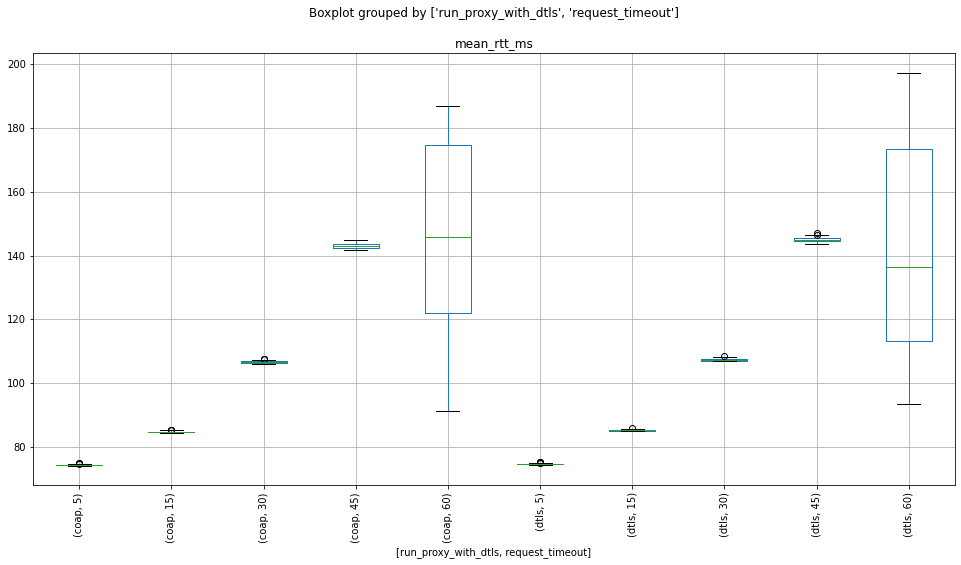

,exp_id,trial,observer_id,num_messages,num_successful_messages,mean_rps,num_retransmissions,stddev_rtt_ms,min_rtt_ms,median_rtt_ms,...,topology_name,num_proxy_connections,request_timeout,max_retries,keep_alive_duration,request_retry_interval,reuse_connections,run_proxy_with_dtls,run_proxy_with_https,run_attacker
240,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,client1,1569,1565,13.041667,7,458.665663,51.578999,52.538514,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,reuse-connections,coap,https,attacker
241,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,client2,1581,1576,13.133333,6,340.547876,51.500082,52.504063,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,reuse-connections,coap,https,attacker
242,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,client3,1580,1574,13.116667,7,342.951481,51.608086,52.510977,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,reuse-connections,coap,https,attacker
243,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,client4,1581,1575,13.125000,6,430.066492,51.730156,52.524567,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,reuse-connections,coap,https,attacker
244,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,client5,1586,1579,13.158333,7,338.681061,51.603079,52.495003,...,thesis_cloud_proxy_and_internet_attacker,50,5,2,5,1,reuse-connections,coap,https,attacker
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client,5,client4,635,634,5.283333,8,876.014921,52.173138,53.039432,...,thesis_cloud_proxy_and_internet_attacker,50,60,2,5,1,reuse-connections,dtls,https,attacker
396,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client,5,client5,616,615,5.125000,7,1205.288286,52.356958,52.983046,...,thesis_cloud_proxy_and_internet_attacker,50,60,2,5,1,reuse-connections,dtls,https,attacker
397,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client,5,client6,597,596,4.966667,8,1581.210999,52.325964,53.005576,...,thesis_cloud_proxy_and_internet_attacker,50,60,2,5,1,reuse-connections,dtls,https,attacker
398,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client,5,client7,577,576,4.800000,7,1585.711538,52.164078,52.989960,...,thesis_cloud_proxy_and_internet_attacker,50,60,2,5,1,reuse-connections,dtls,https,attacker


In [35]:
param_comparison_scope = ["run_proxy_with_dtls", "request_timeout"]

df = client_rps_df.sort_values(by=param_comparison_scope)

plot_args = {
  "rot": 90,
  "by": param_comparison_scope,
}

df.boxplot("mean_rtt_ms", **plot_args)

plt.show()

df

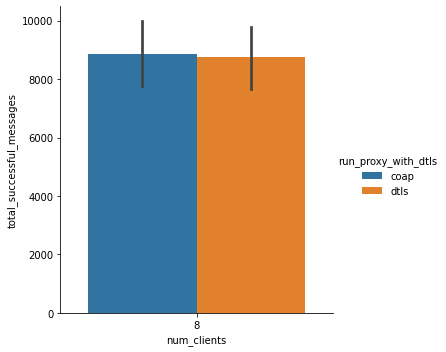

,exp_id,run_proxy_with_dtls,num_clients,trial,total_successful_messages
0,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client,coap,8,1,11115
1,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client,coap,8,2,11116
2,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client,coap,8,3,11111
3,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client,coap,8,4,11095
4,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client,coap,8,5,11120
5,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client,dtls,8,1,11012
6,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client,dtls,8,2,10978
7,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client,dtls,8,3,11012
8,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client,dtls,8,4,10986
9,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client,dtls,8,5,10990


In [36]:
df = (
  client_rps_df
  .groupby(by=["exp_id", "run_proxy_with_dtls", "num_clients", "trial"])
  .agg(
    total_successful_messages=("num_successful_messages", "sum")
  )
  .reset_index()
)

g = sns.catplot(
  data=df,
  x="num_clients",
  y="total_successful_messages",
  hue="run_proxy_with_dtls",
  kind="bar",
)

plt.show()

df

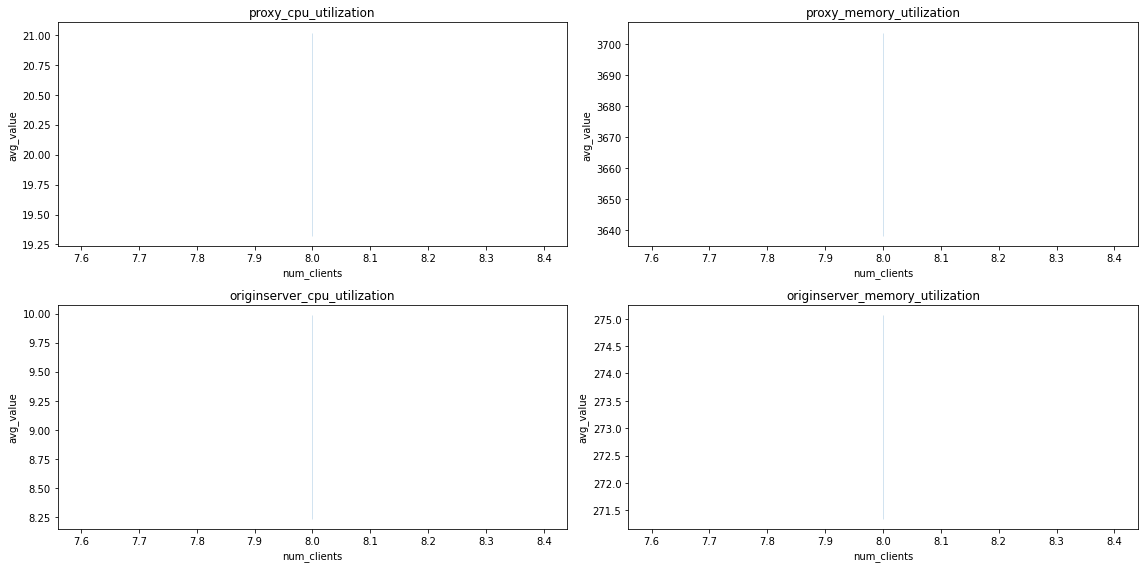

,exp_id,trial,observer_id,metric_type,avg_value,min_value,max_value,attacker_rate,server_connections,max_keep_alive_requests,...,topology_name,num_proxy_connections,request_timeout,max_retries,keep_alive_duration,request_retry_interval,reuse_connections,run_proxy_with_dtls,run_proxy_with_https,run_attacker
0,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,originserver,cpu_utilization,6.491429,0.4,23.7,100mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,15,2,5,1,True,False,True,True
1,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,proxy,cpu_utilization,17.980714,0.5,84.2,100mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,15,2,5,1,True,False,True,True
2,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,originserver,memory_utilization,267.271523,242.0,298.0,100mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,15,2,5,1,True,False,True,True
3,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,proxy,memory_utilization,3619.836394,248.0,6077.0,100mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,15,2,5,1,True,False,True,True
4,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client,2,originserver,cpu_utilization,6.098571,0.5,22.1,100mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,15,2,5,1,True,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client,4,proxy,memory_utilization,3628.232441,252.0,6385.0,100mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,60,2,5,1,True,True,True,True
196,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client,5,originserver,cpu_utilization,13.940714,0.4,26.7,100mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,60,2,5,1,True,True,True,True
197,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client,5,proxy,cpu_utilization,24.487857,0.4,85.7,100mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,60,2,5,1,True,True,True,True
198,thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client,5,originserver,memory_utilization,285.458472,256.0,335.0,100mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,60,2,5,1,True,True,True,True


In [37]:
df = metric_df

nodes = ["proxy", "originserver"]
metric_types = ["cpu_utilization", "memory_utilization"]
fig, ax = plt.subplots(len(metric_types), len(nodes))
for i, n in enumerate(nodes):
  for j, m in enumerate(metric_types):
    g = sns.lineplot(
      data=df[
        (df["observer_id"] == n)
        & (df["metric_type"] == m)
      ],
      x="num_clients",
      y="avg_value",
      ax=ax[i,j],
    )
    ax[i,j].set_title(f"{n}_{m}")

fig.tight_layout()
plt.show()

df

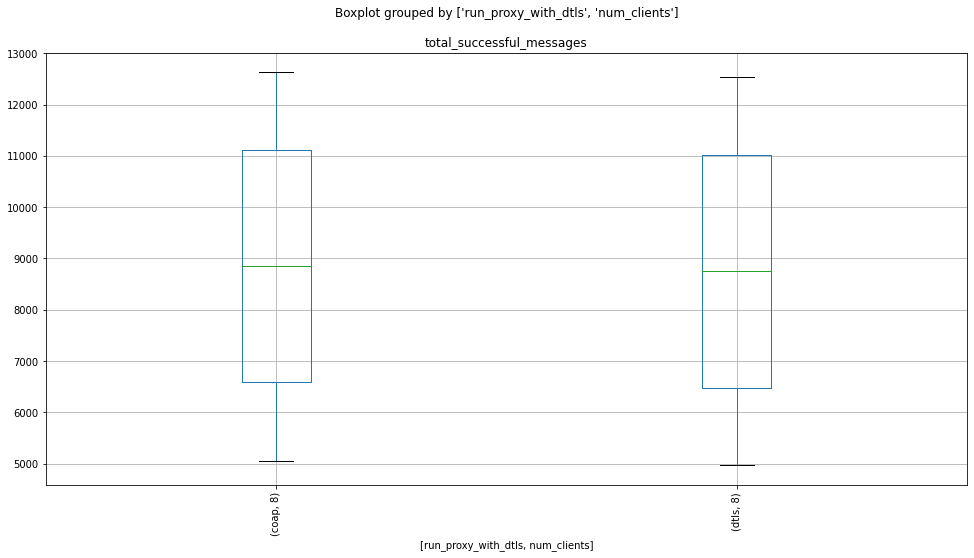

total_successful_messages
exp_id                                                                                                                                           run_proxy_with_dtls num_clients trial                           
thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client coap                8           1                          11115
                                                                                                                                                                                 2                          11116
                                                                                                                                                                                 3                          11111
                                                                                                                                                                                 4                          11095
                                                                                                                                                                                 5                          11120
thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client dtls                8           1                          11012
                                                                                                                                                                                 2                          10978
                                                                                                                                                                                 3                          11012
                                                                                                                                                                                 4                          10986
                                                                                                                                                                                 5                          10990
thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_30sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client coap                8           1                           8846
                                                                                                                                                                                 2                           8837
                                                                                                                                                                                 3                           8827
                                                                                                                                                                                 4                           8866
                                                                                                                                                                                 5                           8855
thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_30sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client dtls                8           1                           8754
                                                                                                                                                                                 2                           8735
                                                                                                                                                                                 3                

In [38]:
df = (
  client_rps_df
  .groupby(by=["exp_id", "run_proxy_with_dtls", "num_clients", "trial"])
  .agg(
    total_successful_messages=("num_successful_messages", "sum")
  )
)
param_comparison_scope = ["run_proxy_with_dtls", "num_clients"]

plot_args = {
  "rot": 90,
  "by": param_comparison_scope,
}

df.boxplot("total_successful_messages", **plot_args)

plt.show()

df